# Data Description

You are provided with historical sales data for 45 Walmart stores located in different regions. Each store contains a number of departments, and you are tasked with predicting the department-wide sales for each store.
In addition, Walmart runs several promotional markdown events throughout the year. These markdowns precede prominent holidays, the four largest of which are the Super Bowl, Labor Day, Thanksgiving, and Christmas. The weeks including these holidays are weighted five times higher in the evaluation than non-holiday weeks. Part of the challenge presented by this competition is modeling the effects of markdowns on these holiday weeks in the absence of complete/ideal historical data.

### stores.csv
This file contains anonymized information about the 45 stores, indicating the type and size of store.

### train.csv
This is the historical training data, which covers to 2010-02-05 to 2012-11-01. Within this file you will find the following fields:
*  Store - the store number
*  Dept - the department number
*  Date - the week
*  Weekly_Sales -  sales for the given department in the given store
*  IsHoliday - whether the week is a special holiday week

### test.csv
This file is identical to train.csv, except we have withheld the weekly sales. **You must predict the sales for each triplet of store, department, and date in this file.**

### features.csv
This file contains additional data related to the store, department, and regional activity for the given dates. It contains the following fields:
*  Store - the store number
*  Date - the week
*  Temperature - average temperature in the region
*  Fuel_Price - cost of fuel in the region
*  MarkDown1-5 - anonymized data related to promotional markdowns that Walmart is running. MarkDown data is only available after Nov 2011, and is not available for all stores all the time. Any missing value is marked with an NA.
*  CPI - the consumer price index
*  Unemployment - the unemployment rate
*  IsHoliday - whether the week is a special holiday week

For convenience, the four holidays fall within the following weeks in the dataset (not all holidays are in the data):
*  Super Bowl: 12-Feb-10, 11-Feb-11, 10-Feb-12, 8-Feb-13
*  Labor Day: 10-Sep-10, 9-Sep-11, 7-Sep-12, 6-Sep-13
*  Thanksgiving: 26-Nov-10, 25-Nov-11, 23-Nov-12, 29-Nov-13
*  Christmas: 31-Dec-10, 30-Dec-11, 28-Dec-12, 27-Dec-13

## Importing libraries

In [1]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import seaborn as sns; sns.set(style="ticks", color_codes=True)
from sklearn.model_selection import train_test_split
from sklearn.ensemble import ExtraTreesRegressor, RandomForestRegressor
from sklearn.neighbors import KNeighborsRegressor
from sklearn.svm import SVR
from sklearn.feature_selection import RFE
from sklearn.neural_network import MLPRegressor
from sklearn.metrics import mean_absolute_error, roc_auc_score
from sklearn.model_selection import KFold
import matplotlib.pyplot as plt

import warnings
warnings.filterwarnings("ignore") # ignoring annoying warnings

from pandasql import sqldf
pysqldf = lambda q: sqldf(q, globals())
from sklearn.cluster import KMeans
%matplotlib inline
import datetime as dt

# import libraries
from datetime import datetime, timedelta

import plotly.offline as pyoff
import plotly.graph_objs as go
#initiate plotly
pyoff.init_notebook_mode()
# Input data files are available in the "./input/" directory.
# For example, running this (by clicking run or pressing Shift+Enter) will list the files in the input directory

import os
print(os.listdir("./input"))

# Any results you write to the current directory are saved as output.

['features.csv', 'sampleSubmission.csv', 'stores.csv', 'test.csv', 'train.csv']


In [2]:
train = pd.read_csv("./input/train.csv", names=['Store','Dept','Date','weeklySales','isHoliday'],sep=',', header=0)
features = pd.read_csv("./input/features.csv",sep=',', header=0,
                       names=['Store','Date','Temperature','Fuel_Price','MarkDown1','MarkDown2','MarkDown3','MarkDown4',
                              'MarkDown5','CPI','Unemployment','IsHoliday']).drop(columns=['IsHoliday'])
stores = pd.read_csv("./input/stores.csv", names=['Store','Type','Size'],sep=',', header=0)

In [3]:
feat_sto = features.merge(stores, how='inner', on='Store')

In [4]:
df = train.merge(feat_sto, 
                           how='inner', on=['Store',
                               'Date']).sort_values(by=['Store',
                                                        'Dept',
                                                        'Date']).reset_index(drop=True)
print(df.shape)
df.head()

(421570, 16)


Store  Dept        Date  weeklySales  isHoliday  Temperature  Fuel_Price  \
0      1     1  2010-02-05     24924.50      False        42.31       2.572   
1      1     1  2010-02-12     46039.49       True        38.51       2.548   
2      1     1  2010-02-19     41595.55      False        39.93       2.514   
3      1     1  2010-02-26     19403.54      False        46.63       2.561   
4      1     1  2010-03-05     21827.90      False        46.50       2.625   

   MarkDown1  MarkDown2  MarkDown3  MarkDown4  MarkDown5         CPI  \
0        NaN        NaN        NaN        NaN        NaN  211.096358   
1        NaN        NaN        NaN        NaN        NaN  211.242170   
2        NaN        NaN        NaN        NaN        NaN  211.289143   
3        NaN        NaN        NaN        NaN        NaN  211.319643   
4        NaN        NaN        NaN        NaN        NaN  211.350143   

   Unemployment Type    Size  
0         8.106    A  151315  
1         8.106    A  151315  
2         8.106    A  151315  
3         8.106    A  151315  
4         8.106    A  151315

dataset = pd.read_csv("./input/train.csv", names=['Store','Dept','Date','weeklySales','isHoliday'],sep=',', header=0)
features = pd.read_csv("./input/features.csv",sep=',', header=0,
                       names=['Store','Date','Temperature','Fuel_Price','MarkDown1','MarkDown2','MarkDown3','MarkDown4',
                              'MarkDown5','CPI','Unemployment','IsHoliday']).drop(columns=['IsHoliday'])
stores = pd.read_csv("./input/stores.csv", names=['Store','Type','Size'],sep=',', header=0)
df = dataset.merge(stores, how='left').merge(features, how='left')

print(df.shape)
df.head()

In [5]:
# Drop duplicate rows and keep the first one:
df = df.drop_duplicates()
df.shape

(421570, 16)

In [6]:
# check data types:
df.columns.to_series().groupby(df.dtypes).groups

{dtype('bool'): Index(['isHoliday'], dtype='object'),
 dtype('int64'): Index(['Store', 'Dept', 'Size'], dtype='object'),
 dtype('float64'): Index(['weeklySales', 'Temperature', 'Fuel_Price', 'MarkDown1', 'MarkDown2',
        'MarkDown3', 'MarkDown4', 'MarkDown5', 'CPI', 'Unemployment'],
       dtype='object'),
 dtype('O'): Index(['Date', 'Type'], dtype='object')}

In [7]:
#converting the type of Date Field from string to datetime.
df['Date'] = pd.to_datetime(df['Date'])
df['Year'] = df['Date'].dt.year
df['Month'] = df['Date'].dt.month
df['Week'] = df['Date'].dt.week
df['Day'] = df['Date'].dt.day

In [8]:
print('Store: ' , df.Store.nunique())
print('Dept: ' , df.Dept.nunique())
print('Type: '+ str(df.Type.nunique()))
print('Size: ', (df.Size.nunique()))
print('MarkDown1: ', (df.MarkDown1.nunique()))
print('MarkDown2: ', (df.MarkDown2.nunique()))
print('MarkDown3: ', (df.MarkDown3.nunique()))
print('MarkDown4: ', (df.MarkDown4.nunique()))
print('MarkDown5: ', (df.MarkDown5.nunique()))
df.isnull().sum()

Store:  45
Dept:  81
Type: 3
Size:  40
MarkDown1:  2277
MarkDown2:  1499
MarkDown3:  1662
MarkDown4:  1944
MarkDown5:  2293


Store                0
Dept                 0
Date                 0
weeklySales          0
isHoliday            0
Temperature          0
Fuel_Price           0
MarkDown1       270889
MarkDown2       310322
MarkDown3       284479
MarkDown4       286603
MarkDown5       270138
CPI                  0
Unemployment         0
Type                 0
Size                 0
Year                 0
Month                0
Week                 0
Day                  0
dtype: int64

In [9]:
null_columns = (df.isnull().sum(axis = 0)/len(df)).sort_values(ascending=False).index
null_data = pd.concat([
    df.isnull().sum(axis = 0),
    (round(100*(df.isnull().sum(axis = 0)/len(df)),2).sort_values(ascending=False)),
    df.loc[:, df.columns.isin(list(null_columns))].dtypes], axis=1)
null_data = null_data.rename(columns={0: '# null', 
                                      1: '% null', 
                                      2: 'type'}).sort_values(ascending=False, by = '% null')
null_data = null_data[null_data["# null"]!=0]
null_data

# null  % null     type
MarkDown2  310322   73.61  float64
MarkDown4  286603   67.98  float64
MarkDown3  284479   67.48  float64
MarkDown1  270889   64.26  float64
MarkDown5  270138   64.08  float64

In [10]:
# dealing with na:
df = df.fillna(0)
df.isnull().sum()

Store           0
Dept            0
Date            0
weeklySales     0
isHoliday       0
Temperature     0
Fuel_Price      0
MarkDown1       0
MarkDown2       0
MarkDown3       0
MarkDown4       0
MarkDown5       0
CPI             0
Unemployment    0
Type            0
Size            0
Year            0
Month           0
Week            0
Day             0
dtype: int64

## Holidays' Analysis

In [11]:
pysqldf("""
SELECT
    T.*,
    case
        when ROW_NUMBER() OVER(partition by Year order by week) = 1 then 'Super Bowl'
        when ROW_NUMBER() OVER(partition by Year order by week) = 2 then 'Labor Day'
        when ROW_NUMBER() OVER(partition by Year order by week) = 3 then 'Thanksgiving'
        when ROW_NUMBER() OVER(partition by Year order by week) = 4 then 'Christmas'
    end as Holyday,
    case
        when ROW_NUMBER() OVER(partition by Year order by week) = 1 then 'Sunday'
        when ROW_NUMBER() OVER(partition by Year order by week) = 2 then 'Monday'
        when ROW_NUMBER() OVER(partition by Year order by week) = 3 then 'Thursday'
        when ROW_NUMBER() OVER(partition by Year order by week) = 4 and Year = 2010 then 'Saturday'
        when ROW_NUMBER() OVER(partition by Year order by week) = 4 and Year = 2011 then 'Sunday'
        when ROW_NUMBER() OVER(partition by Year order by week) = 4 and Year = 2012 then 'Tuesday'
    end as Day
    from(
        SELECT DISTINCT
            Year,
            Week
        FROM df
        WHERE IsHoliday = True) as T""")

Year  Week       Holyday       Day
0  2010     6    Super Bowl    Sunday
1  2010    36     Labor Day    Monday
2  2010    47  Thanksgiving  Thursday
3  2010    52     Christmas  Saturday
4  2011     6    Super Bowl    Sunday
5  2011    36     Labor Day    Monday
6  2011    47  Thanksgiving  Thursday
7  2011    52     Christmas    Sunday
8  2012     6    Super Bowl    Sunday
9  2012    36     Labor Day    Monday

We can see, there are some important Holiday not included in 'IsHoliday'. e.g. Eid Alfeter and Eid Aladha.

In here, I'll demonstrate by adding the Easter holidays. It is always in a Sunday, but can fall on different weeks.

* In 2010 is in Week 13
* In 2011, Week 16
* Week 14 in 2012
* and, finally, Week 13 in 2013 for Test set

So, we can change to 'True' these Weeks in each Year.

df.loc[(df.Year==2010) & (df.Week==13), 'IsHoliday'] = True
df.loc[(df.Year==2011) & (df.Week==16), 'IsHoliday'] = True
df.loc[(df.Year==2012) & (df.Week==14), 'IsHoliday'] = True
df.loc[(df.Year==2013) & (df.Week==13), 'IsHoliday'] = True

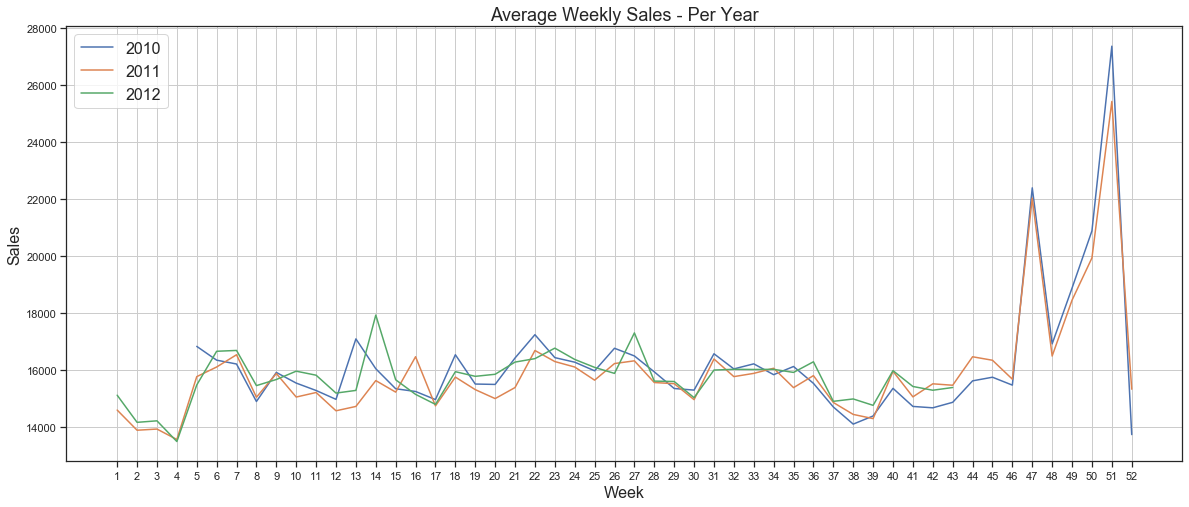

In [12]:
weekly_sales_2010 = df[df.Year==2010]['weeklySales'].groupby(df['Week']).mean()
weekly_sales_2011 = df[df.Year==2011]['weeklySales'].groupby(df['Week']).mean()
weekly_sales_2012 = df[df.Year==2012]['weeklySales'].groupby(df['Week']).mean()
plt.figure(figsize=(20,8))
sns.lineplot(weekly_sales_2010.index, weekly_sales_2010.values)
sns.lineplot(weekly_sales_2011.index, weekly_sales_2011.values)
sns.lineplot(weekly_sales_2012.index, weekly_sales_2012.values)
plt.grid()
plt.xticks(np.arange(1, 53, step=1))
plt.legend(['2010', '2011', '2012'], loc='best', fontsize=16)
plt.title('Average Weekly Sales - Per Year', fontsize=18)
plt.ylabel('Sales', fontsize=16)
plt.xlabel('Week', fontsize=16)
plt.show()

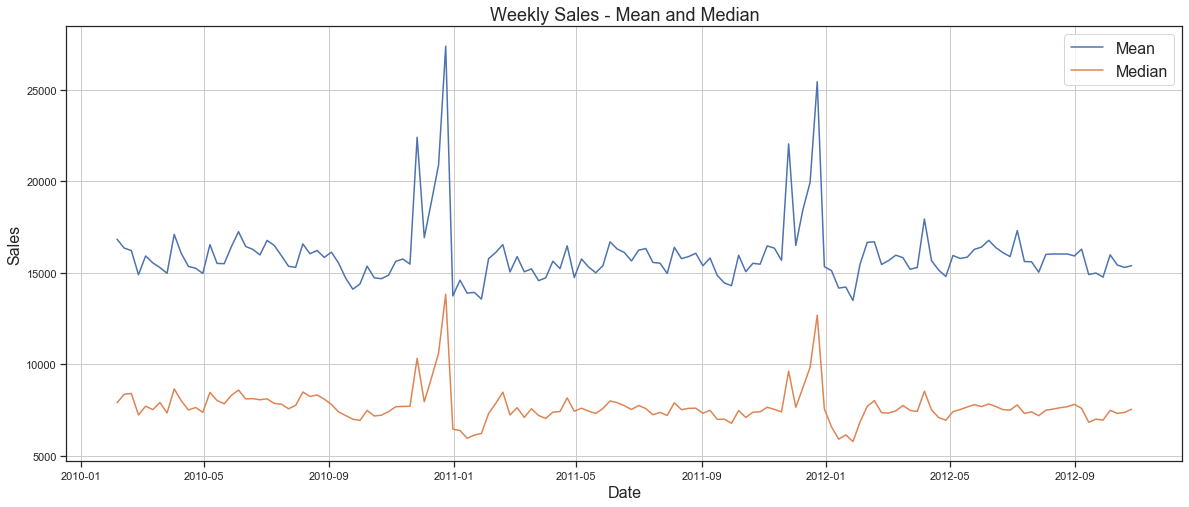

In [13]:
weekly_sales_mean = df['weeklySales'].groupby(df['Date']).mean()
weekly_sales_median = df['weeklySales'].groupby(df['Date']).median()
plt.figure(figsize=(20,8))
sns.lineplot(weekly_sales_mean.index, weekly_sales_mean.values)
sns.lineplot(weekly_sales_median.index, weekly_sales_median.values)
plt.grid()
plt.legend(['Mean', 'Median'], loc='best', fontsize=16)
plt.title('Weekly Sales - Mean and Median', fontsize=18)
plt.ylabel('Sales', fontsize=16)
plt.xlabel('Date', fontsize=16)
plt.show()

## Weekly sales per store:

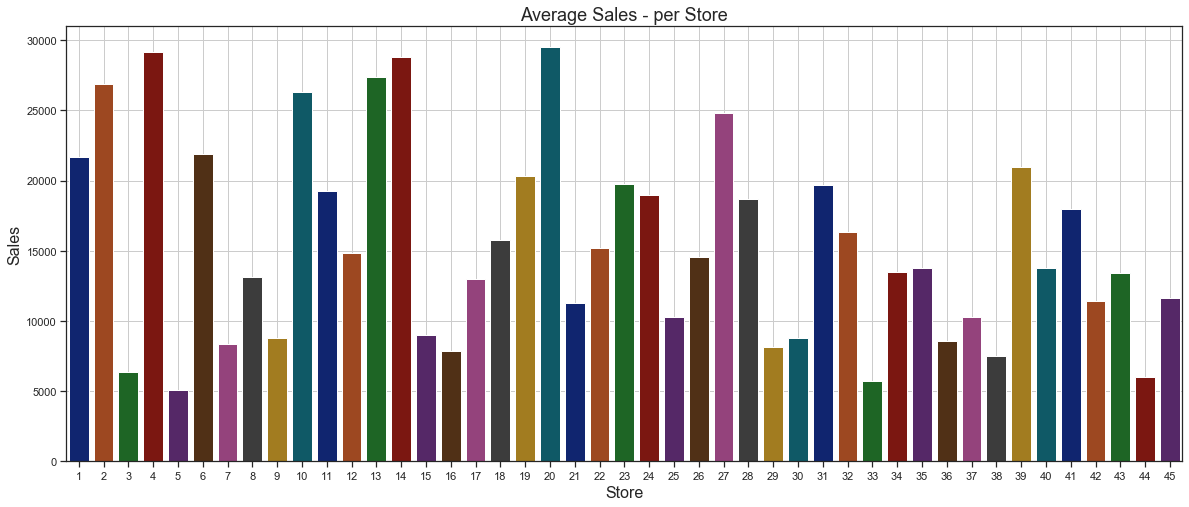

In [14]:
weekly_sales = df['weeklySales'].groupby(df['Store']).mean()
plt.figure(figsize=(20,8))
sns.barplot(weekly_sales.index, weekly_sales.values, palette='dark')
plt.grid()
plt.title('Average Sales - per Store', fontsize=18)
plt.ylabel('Sales', fontsize=16)
plt.xlabel('Store', fontsize=16)
plt.show()

## Weekly sales per dept:

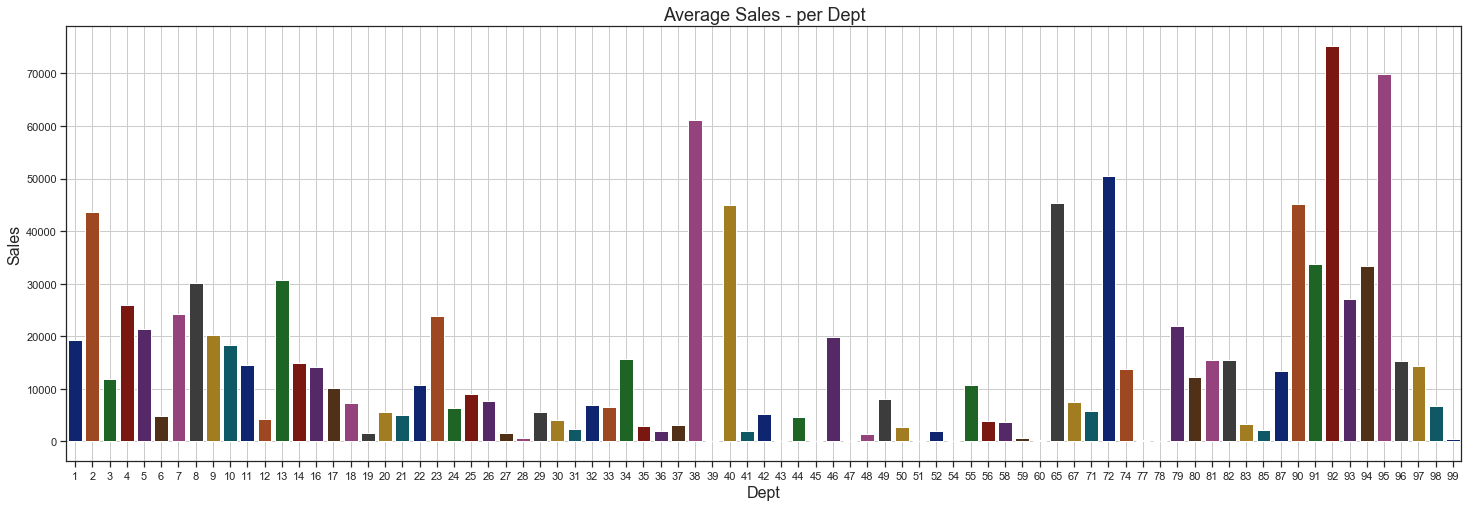

In [15]:
weekly_sales = df['weeklySales'].groupby(df['Dept']).mean()
plt.figure(figsize=(25,8))
sns.barplot(weekly_sales.index, weekly_sales.values, palette='dark')
plt.grid()
plt.title('Average Sales - per Dept', fontsize=18)
plt.ylabel('Sales', fontsize=16)
plt.xlabel('Dept', fontsize=16)
plt.show()

# Data exploration

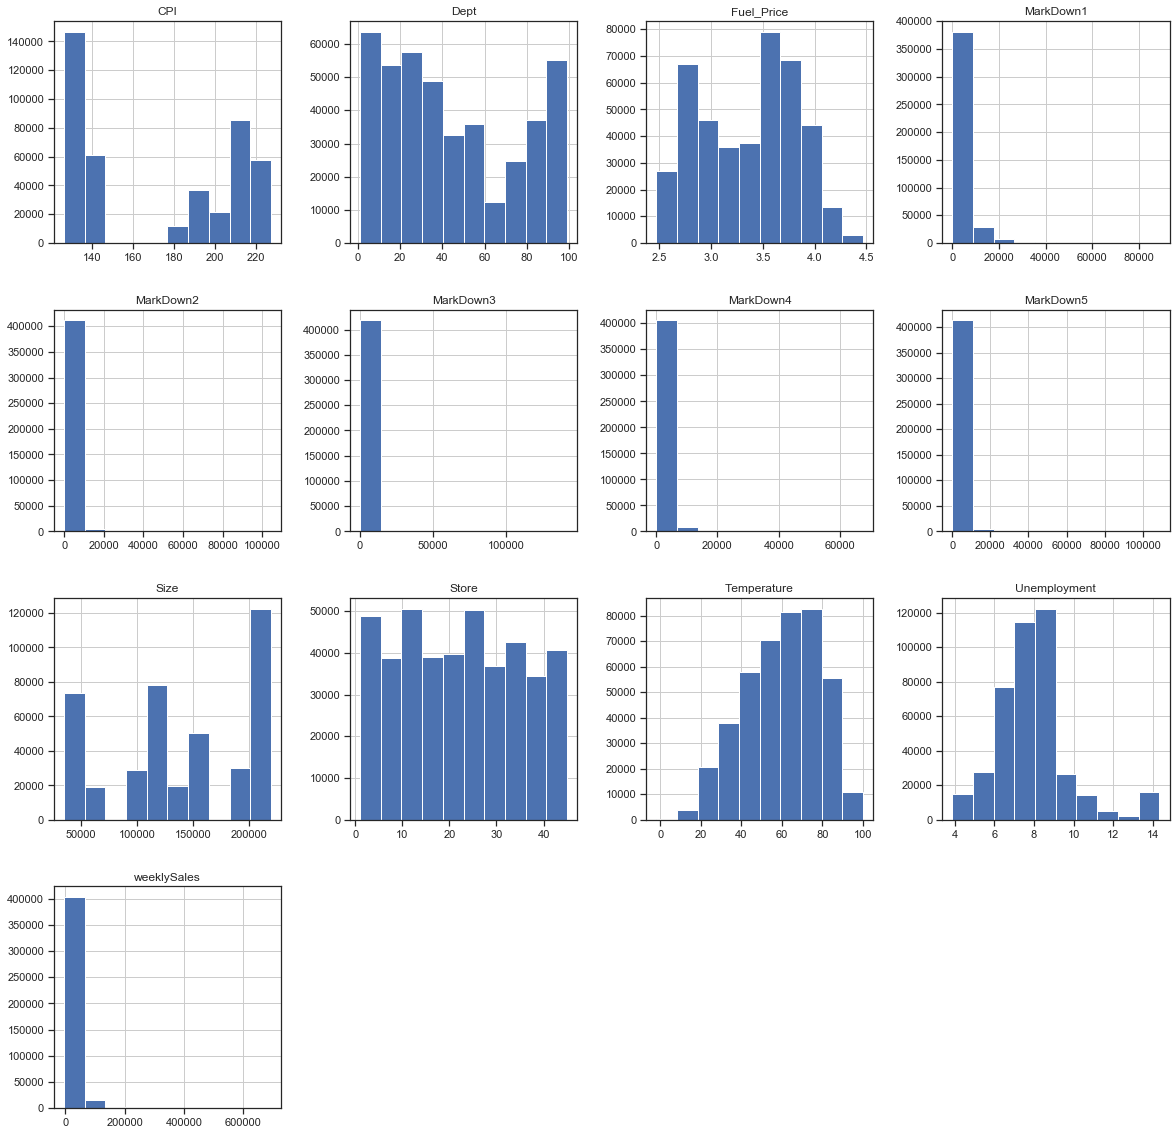

In [16]:
df_his= df[['Store', 'Dept', 'Size','weeklySales', 'Temperature', 'Fuel_Price', 'MarkDown1', 'MarkDown2',
        'MarkDown3', 'MarkDown4', 'MarkDown5', 'CPI', 'Unemployment']]
df_his.hist(figsize=(20,20))
plt.show()

In [17]:
def scatter(dataset, column):
    plt.figure()
    plt.scatter(dataset[column] , dataset['weeklySales'])
    plt.ylabel('weeklySales')
    plt.xlabel(column)

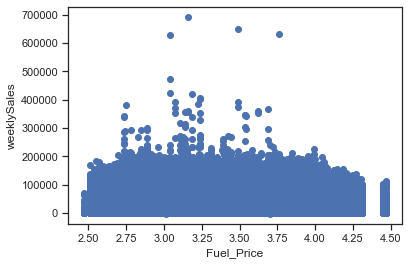

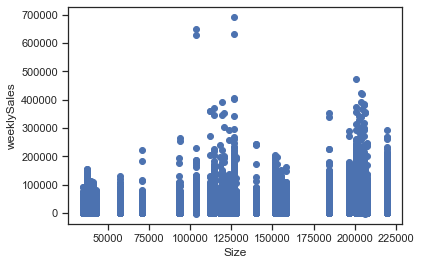

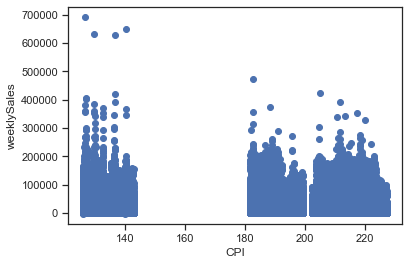

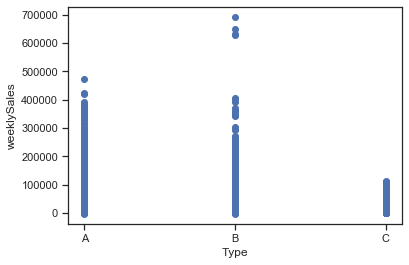

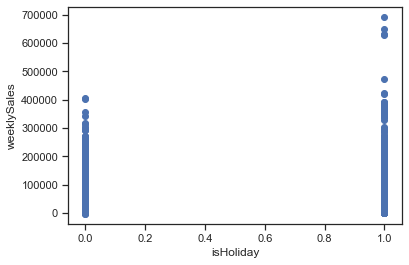

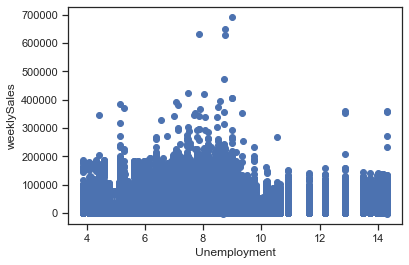

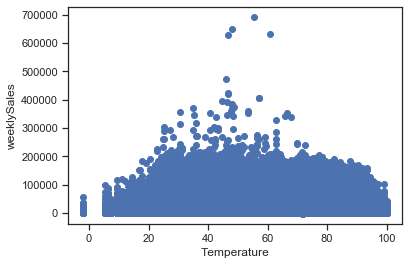

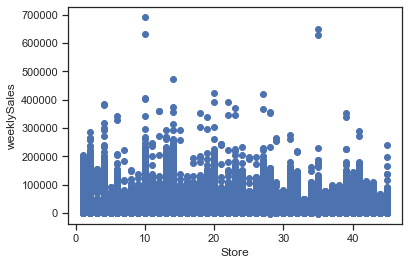

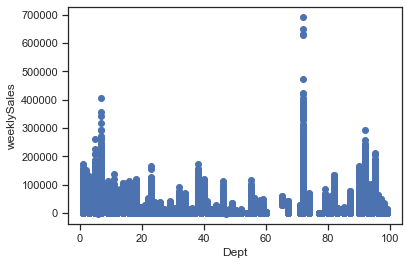

In [18]:
scatter(df, 'Fuel_Price')
scatter(df, 'Size')
scatter(df, 'CPI')
scatter(df, 'Type')
scatter(df, 'isHoliday')
scatter(df, 'Unemployment')
scatter(df, 'Temperature')
scatter(df, 'Store')
scatter(df, 'Dept')

In [19]:
Var_Corr = df.corr()
Var_Corr

Store      Dept  weeklySales  isHoliday  Temperature  \
Store         1.000000  0.024004    -0.085195  -0.000548    -0.050097   
Dept          0.024004  1.000000     0.148032   0.000916     0.004437   
weeklySales  -0.085195  0.148032     1.000000   0.012774    -0.002312   
isHoliday    -0.000548  0.000916     0.012774   1.000000    -0.155949   
Temperature  -0.050097  0.004437    -0.002312  -0.155949     1.000000   
Fuel_Price    0.065290  0.003572    -0.000120  -0.078281     0.143859   
MarkDown1    -0.059844  0.001494     0.047172  -0.003521    -0.026415   
MarkDown2    -0.033829  0.000587     0.020716   0.207604    -0.179672   
MarkDown3    -0.020331  0.001475     0.038562   0.266471    -0.056026   
MarkDown4    -0.042724  0.001937     0.037467   0.011565    -0.050281   
MarkDown5    -0.012452  0.002668     0.050465  -0.015235    -0.014752   
CPI          -0.211088 -0.007477    -0.020921  -0.001944     0.182112   
Unemployment  0.208552  0.007837    -0.025864   0.010460     0.096730   
Size         -0.182881 -0.002966     0.243828   0.000593    -0.058313   
Year          0.002997  0.003738    -0.010111  -0.056746     0.065814   
Month         0.001011  0.000904     0.028409   0.123376     0.235983   
Week          0.001031  0.000882     0.027673   0.128184     0.236276   
Day          -0.000015 -0.000678    -0.006187   0.045465     0.026832   

              Fuel_Price  MarkDown1  MarkDown2  MarkDown3  MarkDown4  \
Store           0.065290  -0.059844  -0.033829  -0.020331  -0.042724   
Dept            0.003572   0.001494   0.000587   0.001475   0.001937   
weeklySales    -0.000120   0.047172   0.020716   0.038562   0.037467   
isHoliday      -0.078281  -0.003521   0.207604   0.266471   0.011565   
Temperature     0.143859  -0.026415  -0.179672  -0.056026  -0.050281   
Fuel_Price      1.000000   0.297056   0.029153   0.018615   0.166622   
MarkDown1       0.297056   1.000000   0.174868  -0.014411   0.838904   
MarkDown2       0.029153   0.174868   1.000000  -0.006080   0.113250   
MarkDown3       0.018615  -0.014411  -0.006080   1.000000  -0.012020   
MarkDown4       0.166622   0.838904   0.113250  -0.012020   1.000000   
MarkDown5       0.215420   0.415050   0.131735   0.042471   0.303370   
CPI            -0.164210   0.010915  -0.003554  -0.005839  -0.002047   
Unemployment   -0.033853  -0.105168  -0.041427  -0.018078  -0.076513   
Size            0.003361   0.169788   0.078372   0.033641   0.127334   
Year            0.779633   0.501044   0.131867   0.006789   0.335340   
Month          -0.040876  -0.089206  -0.019360   0.116031  -0.105569   
Week           -0.031140  -0.093572  -0.012812   0.122323  -0.114168   
Day             0.028058  -0.126187   0.051971   0.072156  -0.152753   

              MarkDown5       CPI  Unemployment      Size      Year     Month  \
Store         -0.012452 -0.211088      0.208552 -0.182881  0.002997  0.001011   
Dept           0.002668 -0.007477      0.007837 -0.002966  0.003738  0.000904   
weeklySales    0.050465 -0.020921     -0.025864  0.243828 -0.010111  0.028409   
isHoliday     -0.015235 -0.001944      0.010460  0.000593 -0.056746  0.123376   
Temperature   -0.014752  0.182112      0.096730 -0.058313  0.065814  0.235983   
Fuel_Price     0.215420 -0.164210     -0.033853  0.003361  0.779633 -0.040876   
MarkDown1      0.415050  0.010915     -0.105168  0.169788  0.501044 -0.089206   
MarkDown2      0.131735 -0.003554     -0.041427  0.078372  0.131867 -0.019360   
MarkDown3      0.042471 -0.005839     -0.018078  0.033641  0.006789  0.116031   
MarkDown4      0.303370 -0.002047     -0.076513  0.127334  0.335340 -0.105569   
MarkDown5      1.000000  0.067906     -0.120406  0.153011  0.402964  0.055770   
CPI            0.067906  1.000000     -0.299953 -0.003314  0.074544  0.005282   
Unemployment  -0.120406 -0.299953      1.000000 -0.068238 -0.237161 -0.012444   
Size           0.153011 -0.003314     -0.068238  1.000000 -0.004975 -0.001210   
Year           0.402964  0.074544     -0.2371

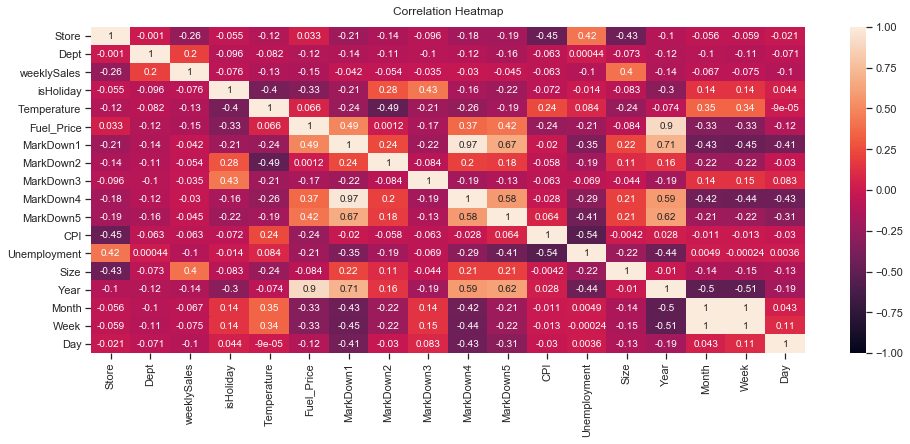

In [20]:
# Increase the size of the heatmap.
plt.figure(figsize=(16, 6))
# Store heatmap object in a variable to easily access it when you want to include more features (such as title).
# Set the range of values to be displayed on the colormap from -1 to 1, and set the annotation to True to display the correlation values on the heatmap.
heatmap = sns.heatmap(Var_Corr.corr(), vmin=-1, vmax=1, annot=True)
# Give a title to the heatmap. Pad defines the distance of the title from the top of the heatmap.
heatmap.set_title('Correlation Heatmap', fontdict={'fontsize':12}, pad=12);

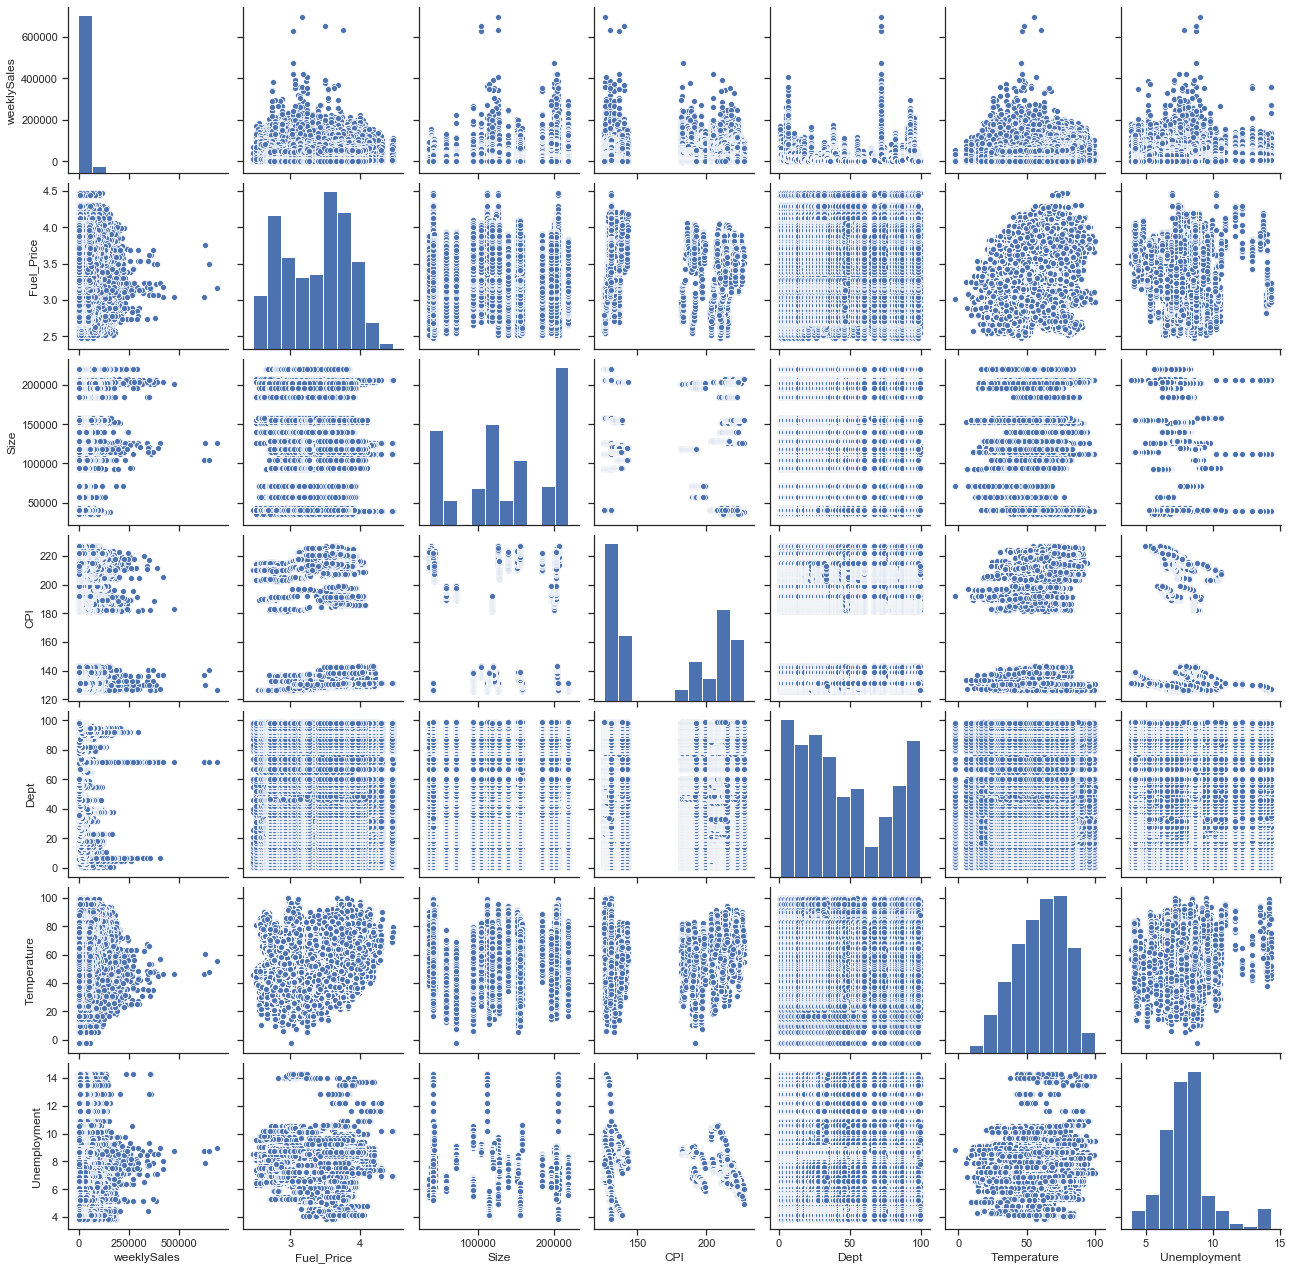

In [21]:
sns.pairplot(df, vars=['weeklySales', 'Fuel_Price', 'Size', 
                       'CPI', 'Dept', 'Temperature', 'Unemployment'])

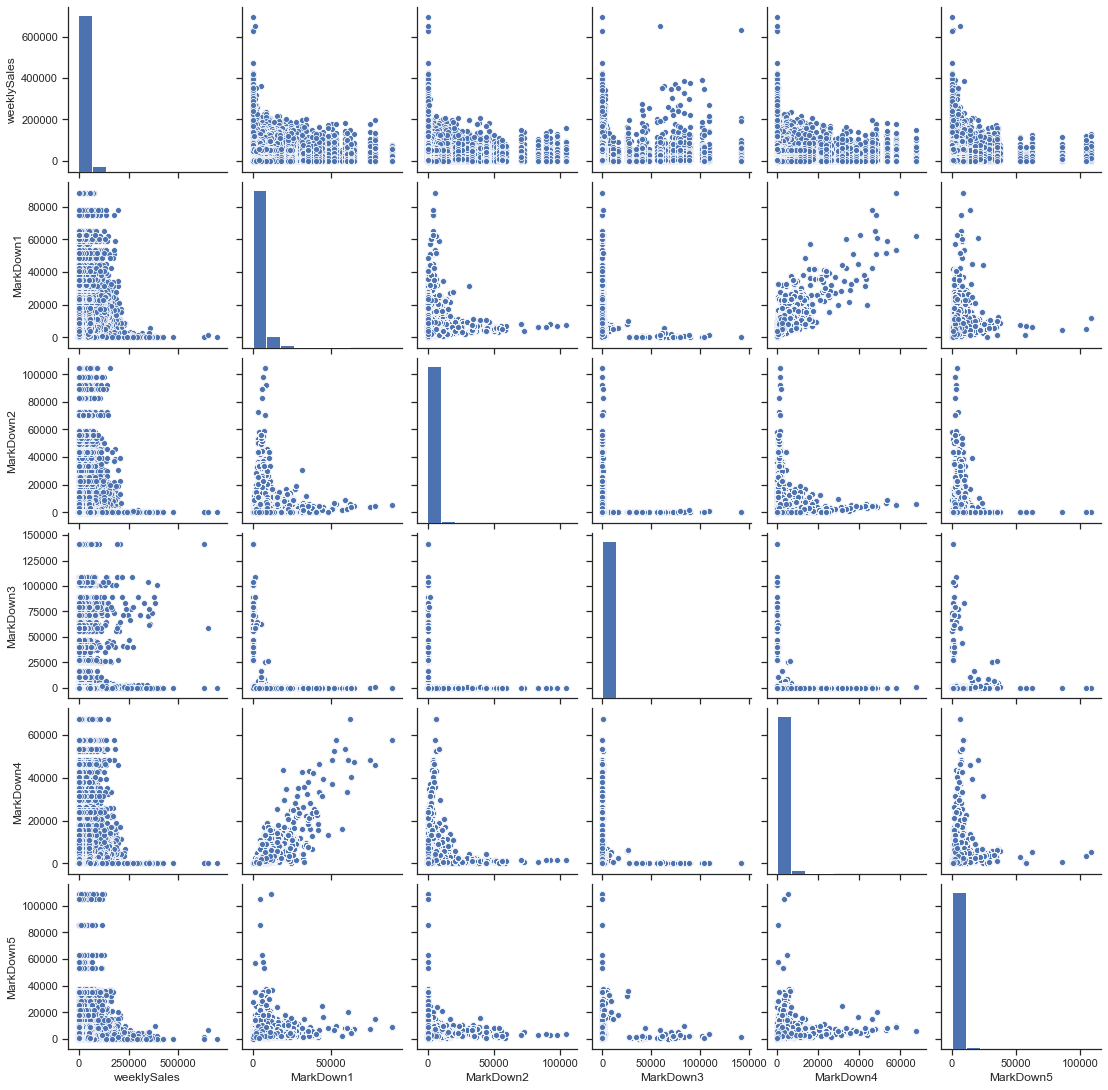

In [22]:
sns.pairplot(df, vars=['weeklySales', 'MarkDown1', 'MarkDown2', 
                                      'MarkDown3', 'MarkDown4', 'MarkDown5'])

# Data Engineering 

In [23]:
df = pd.get_dummies(df, columns=["Type"])
df = df.drop(columns=["Date","Year", "Week","Day", "CPI", "Fuel_Price", 'Unemployment', 'MarkDown4'])
print(df.shape)
df.head()

(421570, 14)


Store  Dept  weeklySales  isHoliday  Temperature  MarkDown1  MarkDown2  \
0      1     1     24924.50      False        42.31        0.0        0.0   
1      1     1     46039.49       True        38.51        0.0        0.0   
2      1     1     41595.55      False        39.93        0.0        0.0   
3      1     1     19403.54      False        46.63        0.0        0.0   
4      1     1     21827.90      False        46.50        0.0        0.0   

   MarkDown3  MarkDown5    Size  Month  Type_A  Type_B  Type_C  
0        0.0        0.0  151315      2       1       0       0  
1        0.0        0.0  151315      2       1       0       0  
2        0.0        0.0  151315      2       1       0       0  
3        0.0        0.0  151315      2       1       0       0  
4        0.0        0.0  151315      3       1       0       0

# Algorithms

In [24]:
def knn():
    knn = KNeighborsRegressor(n_neighbors=10)
    return knn

def extraTreesRegressor():
    clf = ExtraTreesRegressor(n_estimators=100,max_features='auto', verbose=1, n_jobs=1)
    return clf

def randomForestRegressor():
    clf = RandomForestRegressor(n_estimators=100,max_features='log2', verbose=1)
    return clf

def svm():
    clf = SVR(kernel='rbf', gamma='auto')
    return clf

def nn():
    clf = MLPRegressor(hidden_layer_sizes=(10,),  activation='relu', verbose=3)
    return clf

def predict_(m, test_x):
    return pd.Series(m.predict(test_x))

def model_():
#     return knn()
    return extraTreesRegressor()
#     return svm()
#     return nn()
#     return randomForestRegressor()    

def train_(train_x, train_y):
    m = model_()
    m.fit(train_x, train_y)
    return m

def train_and_predict(train_x, train_y, test_x):
    m = train_(train_x, train_y)
    return predict_(m, test_x), m

In [25]:
def calculate_error(test_y, predicted, weights):
    return mean_absolute_error(test_y, predicted, sample_weight=weights)

# K-Fold Cross Validation

In [26]:
kf = KFold(n_splits=5)
splited = []
for name, group in df.groupby(["Store", "Dept"]):
    group = group.reset_index(drop=True)
    trains_x = []
    trains_y = []
    tests_x = []
    tests_y = []
    if group.shape[0] <= 5:
        f = np.array(range(5))
        np.random.shuffle(f)
        group['fold'] = f[:group.shape[0]]
        continue
    fold = 0
    for train_index, test_index in kf.split(group):
        group.loc[test_index, 'fold'] = fold
        fold += 1
    splited.append(group)

splited = pd.concat(splited).reset_index(drop=True)
print(splited.head())
splited.head()

   Store  Dept  weeklySales  isHoliday  Temperature  MarkDown1  MarkDown2  \
0      1     1     24924.50      False        42.31        0.0        0.0   
1      1     1     46039.49       True        38.51        0.0        0.0   
2      1     1     41595.55      False        39.93        0.0        0.0   
3      1     1     19403.54      False        46.63        0.0        0.0   
4      1     1     21827.90      False        46.50        0.0        0.0   

   MarkDown3  MarkDown5    Size  Month  Type_A  Type_B  Type_C  fold  
0        0.0        0.0  151315      2       1       0       0   0.0  
1        0.0        0.0  151315      2       1       0       0   0.0  
2        0.0        0.0  151315      2       1       0       0   0.0  
3        0.0        0.0  151315      2       1       0       0   0.0  
4        0.0        0.0  151315      3       1       0       0   0.0  


Store  Dept  weeklySales  isHoliday  Temperature  MarkDown1  MarkDown2  \
0      1     1     24924.50      False        42.31        0.0        0.0   
1      1     1     46039.49       True        38.51        0.0        0.0   
2      1     1     41595.55      False        39.93        0.0        0.0   
3      1     1     19403.54      False        46.63        0.0        0.0   
4      1     1     21827.90      False        46.50        0.0        0.0   

   MarkDown3  MarkDown5    Size  Month  Type_A  Type_B  Type_C  fold  
0        0.0        0.0  151315      2       1       0       0   0.0  
1        0.0        0.0  151315      2       1       0       0   0.0  
2        0.0        0.0  151315      2       1       0       0   0.0  
3        0.0        0.0  151315      2       1       0       0   0.0  
4        0.0        0.0  151315      3       1       0       0   0.0

In [27]:
best_model = None
error_cv = 0
best_error = np.iinfo(np.int32).max
for fold in range(5):
    df_train = splited.loc[splited['fold'] != fold]
    df_test = splited.loc[splited['fold'] == fold]
    train_y = df_train['weeklySales']
    train_x = df_train.drop(columns=['weeklySales', 'fold'])
    test_y = df_test['weeklySales']
    test_x = df_test.drop(columns=['weeklySales', 'fold'])
    print(df_train.shape, df_test.shape)
    predicted, model = train_and_predict(train_x, train_y, test_x)
    weights = test_x['isHoliday'].replace(True, 5).replace(False, 1)
    error = calculate_error(test_y, predicted, weights)
    error_cv += error
    print(fold, error)
    if error < best_error:
        print('Find best model')
        best_error = error
        best_model = model
error_cv /= 5

(335722, 15) (85552, 15)


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:  2.4min finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    2.4s finished


0 2000.4941614214208
Find best model
(335849, 15) (85425, 15)


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:  2.7min finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    2.3s finished


1 3261.8806145644926
(335970, 15) (85304, 15)


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:  2.6min finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    2.4s finished


2 1914.0883624141316
Find best model
(338733, 15) (82541, 15)


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:  2.6min finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    7.0s finished


3 2347.8771223676486
(338822, 15) (82452, 15)


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:  2.5min finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    2.2s finished


4 1804.7325551143574
Find best model


In [28]:
print('Error_cv: ', round(error_cv, 2), ' & Best_error: ', round(best_error,2))

Error_cv:  2265.81  & Best_error:  1804.73


# Test data

In [29]:
df_test = pd.read_csv("./input/test.csv", names=['Store','Dept','Date','isHoliday'],sep=',', header=0)
df_test = df_test.merge(feat_sto, 
                           how='inner', on=['Store',
                               'Date']).sort_values(by=['Store',
                                                        'Dept',
                                                        'Date']).reset_index(drop=True)
print(df_test.shape)
df_test.head()

(115064, 15)


Store  Dept        Date  isHoliday  Temperature  Fuel_Price  MarkDown1  \
0      1     1  2012-11-02      False        55.32       3.386    6766.44   
1      1     1  2012-11-09      False        61.24       3.314   11421.32   
2      1     1  2012-11-16      False        52.92       3.252    9696.28   
3      1     1  2012-11-23       True        56.23       3.211     883.59   
4      1     1  2012-11-30      False        52.34       3.207    2460.03   

   MarkDown2  MarkDown3  MarkDown4  MarkDown5         CPI  Unemployment Type  \
0    5147.70      50.82    3639.90    2737.42  223.462779         6.573    A   
1    3370.89      40.28    4646.79    6154.16  223.481307         6.573    A   
2     292.10     103.78    1133.15    6612.69  223.512911         6.573    A   
3       4.17   74910.32     209.91     303.32  223.561947         6.573    A   
4        NaN    3838.35     150.57    6966.34  223.610984         6.573    A   

     Size  
0  151315  
1  151315  
2  151315  
3  151315  
4  151315

dataset_test = pd.read_csv("./input/test.csv", names=['Store','Dept','Date','isHoliday'],sep=',', header=0)
features = pd.read_csv("./input/features.csv",sep=',', header=0,
                       names=['Store','Date','Temperature','Fuel_Price','MarkDown1','MarkDown2','MarkDown3','MarkDown4',
                              'MarkDown5','CPI','Unemployment','IsHoliday']).drop(columns=['IsHoliday'])
stores = pd.read_csv("./input/stores.csv", names=['Store','Type','Size'],sep=',', header=0)
df_test = dataset_test.merge(stores, how='left').merge(features, how='left')
print(df_test.shape)
df_test.head()

In [30]:
df_test = pd.get_dummies(df_test, columns=["Type"])
df_test[['MarkDown1','MarkDown2','MarkDown3','MarkDown4', 
         'MarkDown5']] = df_test[['MarkDown1','MarkDown2','MarkDown3','MarkDown4','MarkDown5']].fillna(0)
df_test = df_test.fillna(0)
column_date = df_test['Date']
df_test['Month'] = pd.to_datetime(df_test['Date']).dt.month
df_test = df_test.drop(columns=["Date", "CPI", "Fuel_Price", 'Unemployment', 'MarkDown3'])
print(df_test.shape)
df_test.head()

(115064, 13)


Store  Dept  isHoliday  Temperature  MarkDown1  MarkDown2  MarkDown4  \
0      1     1      False        55.32    6766.44    5147.70    3639.90   
1      1     1      False        61.24   11421.32    3370.89    4646.79   
2      1     1      False        52.92    9696.28     292.10    1133.15   
3      1     1       True        56.23     883.59       4.17     209.91   
4      1     1      False        52.34    2460.03       0.00     150.57   

   MarkDown5    Size  Type_A  Type_B  Type_C  Month  
0    2737.42  151315       1       0       0     11  
1    6154.16  151315       1       0       0     11  
2    6612.69  151315       1       0       0     11  
3     303.32  151315       1       0       0     11  
4    6966.34  151315       1       0       0     11

In [31]:
predicted_test = best_model.predict(df_test)

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    1.9s finished


In [32]:
df_test['weeklySales'] = predicted_test
df_test['Date'] = column_date
df_test['id'] = df_test['Store'].astype(str) + '_' +  df_test['Dept'].astype(str) + '_' +  df_test['Date'].astype(str)
df_test = df_test[['id', 'weeklySales']]
df_test = df_test.rename(columns={'id': 'Id', 'weeklySales': 'Weekly_Sales'})

In [33]:
df_test.to_csv('output.csv', index=False)